<a href="https://colab.research.google.com/github/dcmesh/Solar-Eclipse-Data-Analysis/blob/main/JEF_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Festival of Frequency Measurement Data Analysis

Colab by Joanna Elia based on Jupyter notebook by Kristina Collins KD8OXT, based on FFM code by Aidan Montare KB3UMD.


## Introduction

First, we need to set up out virtual environment. 

Colab is missing some modules and some need to be updated. 

We also need to mount the drive, which will allow Colab to read and write files within your google drive.

Uncomment the cell below and run it once before recommenting it out. Then restart the runtime (under the Runtime tab) so we can utilize the update modules.

Then run the next cell to import all the modules we installed.

In [ ]:
# run once if using Google Collabratory, this will take a while
# uncomment first run, runtime needs to be restarted to use updated modules
'''
!pip install pyproj
!pip install geopandas
!pip install suntime
!pip install -U plotly

#git libaries used
!pip install --user git+https://github.com/matplotlib/basemap.git
!pip install --user git+https://github.com/HamSCI/eclipse_calculator.git

#to grab Rise set Utils
!wget 'https://raw.githubusercontent.com/dcmesh/Solar-Eclipse-Data-Analysis/main/Rise_set_utils.py'

from google.colab import drive
drive.mount('/content/drive')

#'''

"\n!pip install pyproj\n!pip install geopandas\n!pip install suntime\n!pip install -U plotly\n\n#git libaries used\n!pip install --user git+https://github.com/matplotlib/basemap.git\n!pip install --user git+https://github.com/HamSCI/eclipse_calculator.git\n\n#to grab Rise set Utils\n!wget 'https://raw.githubusercontent.com/dcmesh/Solar-Eclipse-Data-Analysis/main/Rise_set_utils.py'\n\nfrom google.colab import drive\ndrive.mount('/content/drive')\n\n#"

In [ ]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.collections as collections
import matplotlib.dates
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns
sns.set(style="darkgrid")
import pyproj
import geopandas
from geopy import distance
from tqdm.notebook import tqdm
from scipy import signal
import itertools
import plotly.graph_objects as go
from plotly.validators.scatter.marker import SymbolValidator

from mpl_toolkits.axes_grid1 import Divider, Size
from mpl_toolkits.axes_grid1.mpl_axes import Axes

from Rise_set_utils import midpoint

# For correlations:
import functools

# register progress_apply with pandas
tqdm.pandas(leave=False)

# import necessary libraries for sunrise and sunset calculations:
import datetime
from datetime import timedelta
from suntime import Sun, SunTimeException

# Eclipse Obscuration Calc:
%pylab inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import eclipse_calc


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version

/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning:

pylab import has clobbered these variables: ['Axes']
`%matplotlib` prevents importing * from pylab and numpy



## Switches and Settings

In [ ]:
# turn this on to generate the stackedplots
# generally, leave this off to make the notebook run faster
PLOT_STACKEDPLOTS = True

# Turn this on to cull the data:
CULL_DATA = True

# turn this on to compute time-delayed correlations (which are pretty slow sometimes)
COMPUTE_LARGE_CORRELATIONS = False

# turn this on to load dask distributed client
LOAD_DASK = False

# turn this on to filter data
FILTER_DATA = True

# run eclipse obsuration map code
MAP = True

# where the figures will be saved
# must end with /
if FILTER_DATA:
    figures_dir = "drive/Shared drives/Solar Eclipse Data Analysis/filtered_plots/"
else:
    figures_dir = "drive/Shared drives/Solar Eclipse Data Analysis/unfiltered_plots/"


start_day = datetime.date(2021, 6, 19)
day_range = 3
day = datetime.date(2020, 6, 21);

# where data directory is located
data_dir = "drive/Shared drives/Solar Eclipse Data Analysis/Colab_Files/"

## Getting Started: Data Import

Let's get some eclipse paths in here, since we'll be needing them soon:

In [ ]:
# Get eclipse traces
from urllib.request import urlopen
import json
with urlopen('https://hamsci.org/sites/default/files/eclipse/experiment/future-eclipses-custom.geojson') as response:
    geojson = json.load(response)

edf=pd.DataFrame()
for i in range(9,17):
    df2=[i, geojson["features"][i]["properties"]['date'], geojson["features"][i]["properties"]['EclipseProperty']]
    df2=pd.DataFrame(df2)
    df2=df2.T
    columns=['id', 'date', 'type']
    if edf.empty:
        edf=df2
    else:
        edf=edf.append(df2)
  
edf.columns=['id', 'date', 'type']


We can map the eclipse traces using either plotly or plotly express:

In [ ]:
# Make an eclipse trace map
fig = px.choropleth_mapbox(edf[0:1], geojson=geojson, color="date",
                           locations="date", featureidkey="properties.date",
                           center={"lat": 20, "lon": 73.7073},
                           mapbox_style="carto-positron", zoom=2)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update(layout_showlegend=False)
fig.show()

fig = px.choropleth(edf, geojson=geojson, color="date",
                           locations="date", featureidkey="properties.date",
                           center={"lat": 20, "lon": 73.7073},
#                            mapbox_style="carto-positron", zoom=2
                   )
fig.update_layout(margin={"r":0,"t":40,"l":40,"b":40})
# fig.update(layout_showlegend=False)
#fig.show()

Next we read in the data. (Bonus points if we can figure out how to do this directly from Zenodo, but for now this notebook can link to the directory of the downloaded files.)

In [ ]:
daystring='200'+str(day.month)+str(day.day)

pedigree = pd.read_csv(data_dir + 'JEF Stations.csv', error_bad_lines=False)   #, dtype={"zID": "object"})
FreqError = pd.read_csv(data_dir + "200621" + '_FreqErr.txt', index_col=0, parse_dates=['UTC'])
Amplitude = pd.read_csv(data_dir + 'Vpk_full.txt', index_col=0, parse_dates=['Time'])


## Set Up Data for Analysis

The "pedigree" file contains metadata for each of the stations that collected 10 MHz data.

In [ ]:
# pedigree.loc([2])
pedigree.loc[48,"Callsign"] = '罗 智文'
pedigree.index_col = "Callsign"
pedigree['Status'] = 'keep'
pedigree

Callsign   Latitude   Longitude GPSDO Status
0            3V1E  25.279901   51.545010    No   keep
1           9V1AW   1.440400  103.791000    No   keep
2           9V1KB   1.423721  103.848027    No   keep
3           A45VU  23.601537   58.348763    No   keep
4           A47RS  23.601909   58.349252    No   keep
5           AD7TS  47.839933 -122.012550   Yes   keep
6            AD8Y  41.493744  -81.578039   Yes   keep
7           DK4BU  51.118011    7.395542    No   keep
8          EA1IUO  43.346667   -8.344372    No   keep
9           EI7IG  52.172530   -7.156710    No   keep
10          F1ABL  44.000000    5.000000    No   keep
11          F4IEW  49.024489    2.324335    No   keep
12          G0LHZ  51.507468    1.080013    No   keep
13    HZ1HM-SU9HM  21.392000   39.879830    No   keep
14         JF9PKH  36.675013  137.238866    No   keep
15       JI3XOK/8  43.742500  142.375000    No   keep
16         JJ1BDX  35.665650  139.633591    No   keep
17           K1FR  38.828238  -77.104402   Yes   keep
18          K6FOD  34.101151 -118.143400   Yes   keep
19          K6RGI  37.953000 -122.535000    No   keep
20         KA3JAW  40.675200  -75.210600    No   keep
21         KD8CGH  41.198818  -81.337331    No   keep
22         KF5SMH  36.880000 -107.990000    No   keep
23           N7MN  41.000000   83.000000    No   keep
24           NA0B  40.516111   79.922778   Yes   keep
25         OE3WYC  48.213628   16.470426   Yes   keep
26         PA0RWT  53.257530    6.958064    No   keep
27         PA0SLT  53.280910    6.906162    No   keep
28          PA4WE  51.502907    5.370516    No   keep
29           PD4C  52.715259    5.734414    No   keep
30         PE1RCW  57.953800   12.136100    No   keep
31         PE1RWP  53.114000    6.114000    No   keep
32         PU3VRW -32.035384  -52.082786    No   keep
33         SA6EAL  57.503388   12.552997    No   keep
34         SP9MUF  50.016290   19.883810    No   keep
35         SP9WPN  50.332800   18.943200    No   keep
36         SV1GRB  38.032781   23.801824    No   keep
37          SV1IT  38.000000   24.000000    No   keep
38         SV1ONK  37.918709   24.025083    No   keep
39          SV1VC  37.835456   23.932275    No   keep
40         SV2BBO  40.593051   22.961592    No   keep
41        SV7BOT   41.131000   25.280000    No   keep
42         SWL-01 -42.969000  147.266000    No   keep
43         VK2DLR -28.768621  153.421964    No   keep
44         VK3DFR -37.880000  145.290000    No   keep
45         VK7KPC -42.569170  147.242300    No   keep
46          W3LLA  40.585258 -105.084419    No   keep
47          ZS6YZ -25.661499   28.174138    No   keep
48           罗 智文  29.500000  106.240000    No   keep
49         JI3XOK  43.742500  142.375000    No   keep
50       PA0WRT-1  53.257530    6.958064    No   keep
51       PA0WRT-2  53.257530    6.958064    No   keep
52       PA0WRT-3  53.257530    6.958064    No   keep
53  PA0WRT-FT450D  53.257530    6.958064    No   keep
54     SP9MUF_RX2  50.016290   19.883810    No   keep

We should verify that all the collected datasets have pedigree entries. If FreqError has any columns not accounted for in pedigree, we're going to run into trouble. 

In [ ]:
(FreqError.columns).difference(pedigree.Callsign)
FreqError=FreqError[pd.Index.intersection(FreqError.columns, pedigree.Callsign)]

Add sunrise and sunset times to our table. 

In [ ]:
for i in pedigree["Callsign"].index.values:
#     print(pedigree.loc[i,"Callsign"], pedigree.loc[i,"Latitude"], pedigree.loc[i,"Longitude"])
    sun = Sun(pedigree.loc[i,"Latitude"], pedigree.loc[i,"Longitude"])
#     abd = datetime.date(2020, 6, 21)
    pedigree.loc[i,"Sunrise"] = sun.get_sunrise_time(day)
    pedigree.loc[i,"Sunset"] = sun.get_sunset_time(day)
pedigree

Callsign   Latitude   Longitude GPSDO Status                    Sunrise                     Sunset
0            3V1E  25.279901   51.545010    No   keep  2020-06-21 01:44:00+00:00  2020-06-21 15:27:00+00:00
1           9V1AW   1.440400  103.791000    No   keep  2020-06-21 23:01:00+00:00  2020-06-21 11:13:00+00:00
2           9V1KB   1.423721  103.848027    No   keep  2020-06-21 23:00:00+00:00  2020-06-21 11:12:00+00:00
3           A45VU  23.601537   58.348763    No   keep  2020-06-21 01:21:00+00:00  2020-06-21 14:56:00+00:00
4           A47RS  23.601909   58.349252    No   keep  2020-06-21 01:21:00+00:00  2020-06-21 14:56:00+00:00
5           AD7TS  47.839933 -122.012550   Yes   keep  2020-06-21 12:10:00+00:00  2020-06-21 04:10:00+00:00
6            AD8Y  41.493744  -81.578039   Yes   keep  2020-06-21 09:53:00+00:00  2020-06-21 01:04:00+00:00
7           DK4BU  51.118011    7.395542    No   keep  2020-06-21 03:15:00+00:00  2020-06-21 19:49:00+00:00
8          EA1IUO  43.346667   -8.344372    No   keep  2020-06-21 04:53:00+00:00  2020-06-21 20:17:00+00:00
9           EI7IG  52.172530   -7.156710    No   keep  2020-06-21 04:08:00+00:00  2020-06-21 20:53:00+00:00
10          F1ABL  44.000000    5.000000    No   keep  2020-06-21 03:57:00+00:00  2020-06-21 19:26:00+00:00
11          F4IEW  49.024489    2.324335    No   keep  2020-06-21 03:47:00+00:00  2020-06-21 19:59:00+00:00
12          G0LHZ  51.507468    1.080013    No   keep  2020-06-21 03:39:00+00:00  2020-06-21 20:17:00+00:00
13    HZ1HM-SU9HM  21.392000   39.879830    No   keep  2020-06-21 02:39:00+00:00  2020-06-21 16:05:00+00:00
14         JF9PKH  36.675013  137.238866    No   keep  2020-06-21 19:33:00+00:00  2020-06-21 10:13:00+00:00
15       JI3XOK/8  43.742500  142.375000    No   keep  2020-06-21 18:49:00+00:00  2020-06-21 10:16:00+00:00
16         JJ1BDX  35.665650  139.633591    No   keep  2020-06-21 19:26:00+00:00  2020-06-21 10:00:00+00:00
17           K1FR  38.828238  -77.104402   Yes   keep  2020-06-21 09:44:00+00:00  2020-06-21 00:37:00+00:00
18          K6FOD  34.101151 -118.143400   Yes   keep  2020-06-21 12:42:00+00:00  2020-06-21 03:07:00+00:00
19          K6RGI  37.953000 -122.535000    No   keep  2020-06-21 12:48:00+00:00  2020-06-21 03:36:00+00:00
20         KA3JAW  40.675200  -75.210600    No   keep  2020-06-21 09:30:00+00:00  2020-06-21 00:35:00+00:00
21         KD8CGH  41.198818  -81.337331    No   keep  2020-06-21 09:53:00+00:00  2020-06-21 01:02:00+00:00
22         KF5SMH  36.880000 -107.990000    No   keep  2020-06-21 11:53:00+00:00  2020-06-21 02:35:00+00:00
23           N7MN  41.000000   83.000000    No   keep  2020-06-21 22:56:00+00:00  2020-06-21 14:03:00+00:00
24           NA0B  40.516111   79.922778   Yes   keep  2020-06-21 23:10:00+00:00  2020-06-21 14:14:00+00:00
25         OE3WYC  48.213628   16.470426   Yes   keep  2020-06-21 02:54:00+00:00  2020-06-21 18:58:00+00:00
26         PA0RWT  53.257530    6.958064    No   keep  2020-06-21 03:05:00+00:00  2020-06-21 20:03:00+00:00
27         PA0SLT  53.280910    6.906162    No   keep  2020-06-21 03:05:00+00:00  2020-06-21 20:04:00+00:00
28          PA4WE  51.502907    5.370516    No   keep  2020-06-21 03:21:00+00:00  2020-06-21 19:59:00+00:00
29           PD4C  52.715259    5.734414    No   keep  2020-06-21 03:13:00+00:00  2020-06-21 20:05:00+00:00
30         PE1RCW  57.953800   12.136100    No   keep  2020-06-21 02:09:00+00:00  2020-06-21 20:18:00+00:00
31         PE1RWP  53.114000    6.114000    No   keep  2020-06-21 03:09:00+00:00  2020-06-21 20:06:00+00:00
32         PU3VRW -32.035384  -52.082786    No   keep  2020-06-21 10:29:00+00:00  2020-06-21 20:32:00+00:00
33         SA6EAL  57.503388   12.552997    No   keep  2020-06-21 02:11:00+00:00  2020-06-21 20:12:00+00:00
34         SP9MUF  50.016290   19.883810    No   keep  2020-06-21 02:31:00+00:00  2020-06-21 18:53:00+00:00
35         SP9WPN  50.332800   18.943200    No   keep  2020-06-21 02:33:00+00:00  2020-06-21 18:59:00+00:00
36         SV

The experimental data from all the stations is organized into tables - one for frequency error, one for amplitude, and so on.

In [ ]:
FreqError.head()
FreqError.columns

#Adding filtering:
filtered_FreqError = FreqError.rolling(window=300, min_periods=1).mean()
unfiltered_FreqError = FreqError
if FILTER_DATA:
    FreqError=filtered_FreqError
    Amplitude = Amplitude.rolling(window=300, min_periods=1).mean()
    

In [ ]:
FreqError.G0LHZ

UTC
2020-06-21 00:00:00   -0.00900
2020-06-21 00:00:01    0.01900
2020-06-21 00:00:02    0.02300
2020-06-21 00:00:03    0.07175
2020-06-21 00:00:04    0.07980
                        ...   
2020-06-21 23:59:55        NaN
2020-06-21 23:59:56        NaN
2020-06-21 23:59:57        NaN
2020-06-21 23:59:58        NaN
2020-06-21 23:59:59        NaN
Name: G0LHZ, Length: 86400, dtype: float64

Culling data:

In [ ]:


# pedigree.loc[pedigree["Callsign"] == "NU0C"]["Status"] = "remove"

if CULL_DATA==True:
    for call in ["3V1E", "K6RGI", "K6FOD"]:
        print(call)
        #index = pedigree[pedigree["Callsign"] == call]
        list(pedigree[pedigree["Callsign"] == call].index.values) 
        pedigree.loc[pedigree[pedigree["Callsign"] == call].index.values, "Status"]  = "remove"


3V1E
K6RGI
K6FOD


Some datasets were culled above.

We discussed which stations appear to have measurement errors on one of our Thursday telecon calls. The notes we generated are in the file `ffm-data-comments.txt`. Kristina also has her own version of this file.

In [ ]:
pedigree[pedigree["Status"] == "remove"]

Callsign   Latitude  Longitude GPSDO  Status                    Sunrise                     Sunset
0      3V1E  25.279901   51.54501    No  remove  2020-06-21 01:44:00+00:00  2020-06-21 15:27:00+00:00
18    K6FOD  34.101151 -118.14340   Yes  remove  2020-06-21 12:42:00+00:00  2020-06-21 03:07:00+00:00
19    K6RGI  37.953000 -122.53500    No  remove  2020-06-21 12:48:00+00:00  2020-06-21 03:36:00+00:00

We can compare that list to the list I made, and indeed, they are the same list of stations.

Rather than outright removing the columns in `FreqError` corresponding to these stations, we'll replace their values with `nan`, the "not a number" value. We'll do this by creating a dataframe of booleans that we can use as a mask: every place with `True` will be kept for analysis, and every place with `False` will be replaced by `nan`.

The advantage of doing this is that we can use the same procedure to mask out parts of a station's record. This will let us remove some of the errors in otherwise fine datasets.

In [ ]:
# dataframe of positions that we will keep
FreqErrorMask = FreqError.applymap(lambda x: True)

Set values as `False` for the stations we are going to remove.

In [ ]:
FreqErrorMask[pedigree[pedigree["Status"] == "remove"]["Callsign"]] = False

And remove the portions of datasets that are otherwise fine:

In [ ]:

# FreqErrorMask.loc["2019-10-01T16:07":"2019-10-01T16:22", "VE6IXD"] = False #3470110
# FreqErrorMask.loc["2019-10-01T15:22":"2019-10-01T16:13", "K0ANS"] = False #3468667
# FreqErrorMask.loc["2019-10-01T23:15":"2019-10-02T00:00", "KA6WKE"] = False #3468667

Here's our mask. It has the same columns and indicies as FreqError.

In [ ]:
FreqErrorMask.head()

罗 智文  ZS6YZ  W3LLA  VK7KPC  VK3DFR  VK2DLR  SWL-01  SV2BBO  SV1VC  SV1IT  SV1GRB  SP9WPN  SP9MUF_RX2  SP9MUF  PE1RWP  PE1RCW  PD4C  PA0WRT-3  PA0WRT-2  PA0WRT-1  PA0SLT  OE3WYC  NA0B  KD8CGH  K6RGI  K6FOD  K1FR  JJ1BDX  JI3XOK  JF9PKH  G0LHZ  F4IEW  F1ABL  DK4BU  AD7TS  A47RS  A45VU  9V1KB  9V1AW   3V1E
UTC                                                                                                                                                                                                                                                                                                                                  
2020-06-21 00:00:00  True   True   True    True    True    True    True    True   True   True    True    True        True    True    True    True  True      True      True      True    True    True  True    True  False  False  True    True    True    True   True   True   True   True   True   True   True   True   True  False
2020-06-21 00:00:01  True   True   True    True    True    True    True    True   True   True    True    True        True    True    True    True  True      True      True      True    True    True  True    True  False  False  True    True    True    True   True   True   True   True   True   True   True   True   True  False
2020-06-21 00:00:02  True   True   True    True    True    True    True    True   True   True    True    True        True    True    True    True  True      True      True      True    True    True  True    True  False  False  True    True    True    True   True   True   True   True   True   True   True   True   True  False
2020-06-21 00:00:03  True   True   True    True    True    True    True    True   True   True    True    True        True    True    True    True  True      True      True      True    True    True  True    True  False  False  True    True    True    True   True   True   True   True   True   True   True   True   True  False
2020-06-21 00:00:04  True   True   True    True    True    True    True    True   True   True    True    True        True    True    True    True  True      True      True      True    True    True  True    True  False  False  True    True    True    True   True   True   True   True   True   True   True   True   True  False

We can visualize the mask by creating an image of it. Below, light values (1's) are True, and dark values (0's )are False.

In [ ]:
# sns.heatmap(FreqErrorMask.astype('int'))
# plt.show()

To apply the mask, we use `.where`.

In [ ]:
# FreqError.where(FreqErrorMask).head()

To check that the mask had the intended effect, let's make before and after images showing the location of `nan`'s in FreqError. 

Before:

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 32599 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 26234 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 25991 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 32599 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 26234 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 25991 missing from current font.



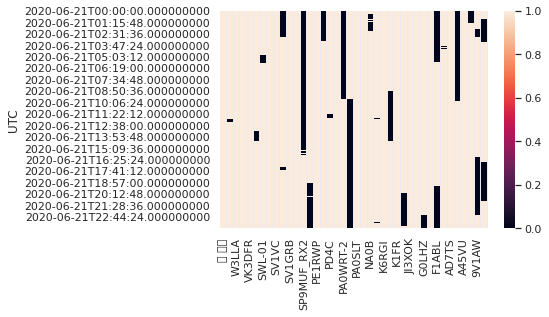

In [ ]:
sns.heatmap(FreqError.notna().astype('int'))
plt.show()

Note that even the original FreqError dataframe is missing a lot of values. Some of the data may have been eliminated because of the use of matlab's synchronise function to prepare the unified table in the zenodo upload.
https://www.mathworks.com/help/matlab/ref/timetable.synchronize.html

After:

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 32599 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 26234 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 25991 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 32599 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 26234 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 25991 missing from current font.



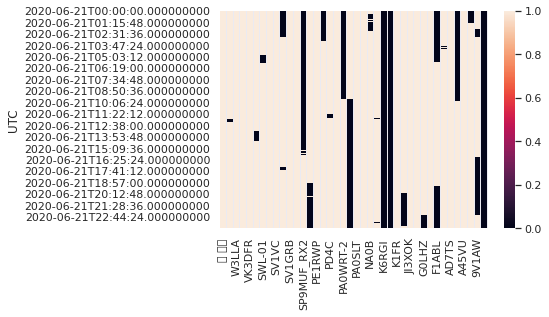

In [ ]:
sns.heatmap(FreqError.where(FreqErrorMask).notna().astype('int'))
plt.show()

In [ ]:
## combined before and after plot
#
#f, axes = plt.subplots(1,2, figsize=(14,6), sharey=True)
#
#sns.heatmap(FreqError.notna().astype('int'), ax=axes[0])
#
#sns.heatmap(FreqError.where(FreqErrorMask).notna().astype('int'), ax=axes[1])
#
#plt.subplots_adjust(top=0.7)
#f.suptitle("Before and after the application of the mask")
#plt.tight_layout()
#plt.show()

Note these kinds of heatmaps also give us another way of visualizing the frequency error data. It doesn't seem as easy to read as the stackedplots, though.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 32599 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 26234 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 25991 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 32599 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 26234 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 25991 missing from current font.



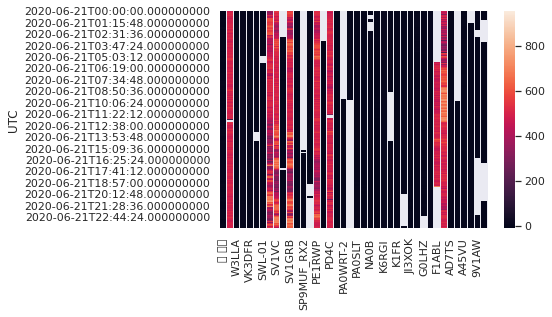

In [ ]:
sns.heatmap(FreqError)
plt.show()

Now let's re-reun the correlations using our masked (we'll call it culled) dataset.

In [ ]:
culled_FreqErrorCorrelations = FreqError.where(FreqErrorMask).corr()

In [ ]:
culled_FreqErrorCorrelations.head()

罗 智文     ZS6YZ     W3LLA    VK7KPC    VK3DFR    VK2DLR    SWL-01    SV2BBO     SV1VC     SV1IT    SV1GRB    SP9WPN  SP9MUF_RX2    SP9MUF    PE1RWP    PE1RCW      PD4C  PA0WRT-3  PA0WRT-2  PA0WRT-1    PA0SLT    OE3WYC      NA0B    KD8CGH  K6RGI  K6FOD      K1FR    JJ1BDX    JI3XOK    JF9PKH     G0LHZ     F4IEW     F1ABL     DK4BU     AD7TS     A47RS     A45VU     9V1KB     9V1AW  3V1E
罗 智文    1.000000  0.048272 -0.509885  0.135416  0.154142  0.222401  0.210319 -0.334849 -0.006451  0.080534 -0.111353  0.224839   -0.059256  0.371210 -0.205116 -0.458915  0.012796  0.411169 -0.412709 -0.123519 -0.556521  0.129585 -0.037930 -0.508630    NaN    NaN  0.006459  0.099195 -0.029184 -0.246454  0.156235  0.194530  0.143592 -0.092045  0.236394  0.313316  0.184401  0.338539  0.124944   NaN
ZS6YZ   0.048272  1.000000  0.001948  0.031989  0.055558  0.007477  0.000474  0.014946 -0.049914  0.001678 -0.048859 -0.009952    0.031294 -0.036749  0.052057  0.003027  0.038944  0.033457  0.048641 -0.058885 -0.001893 -0.019527  0.040344 -0.016502    NaN    NaN  0.108545 -0.066636 -0.014022 -0.008642 -0.022121  0.024087 -0.044191  0.005395 -0.036061 -0.017345 -0.033321 -0.013899 -0.078996   NaN
W3LLA  -0.509885  0.001948  1.000000 -0.373607 -0.437122 -0.609232 -0.644441  0.329463  0.016411  0.109684  0.114212 -0.103555    0.186977 -0.212851  0.425558  0.733748 -0.034029 -0.730401  0.814385 -0.064219  0.877093  0.033593  0.252657  0.746657    NaN    NaN -0.410442 -0.341392 -0.271044  0.400814  0.132781  0.127460 -0.282054 -0.210976 -0.456178  0.425677  0.233658 -0.100308  0.176784   NaN
VK7KPC  0.135416  0.031989 -0.373607  1.000000  0.472843  0.255208  0.459817 -0.358586 -0.131215  0.108537 -0.349996  0.104196    0.070147  0.302117 -0.223233 -0.205709  0.025916  0.367910  0.005875  0.103464 -0.353469  0.037972 -0.036731 -0.214629    NaN    NaN  0.171796  0.364355  0.165095 -0.039892  0.016640  0.044745  0.215755  0.040894  0.144811  0.070763 -0.011044  0.189670 -0.025968   NaN
VK3DFR  0.154142  0.055558 -0.437122  0.472843  1.000000  0.807665  0.109714 -0.018804 -0.060032  0.376320 -0.118456  0.298517    0.193865  0.343258 -0.291732 -0.343281  0.048808  0.706987  0.520529  0.162767 -0.567255  0.157903 -0.048204 -0.600927    NaN    NaN -0.056360  0.575787  0.632357  0.020124  0.061637  0.216589  0.136048 -0.052026 -0.059850  0.592347  0.247812  0.508422  0.330349   NaN

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 32599 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 26234 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 25991 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 32599 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 26234 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 25991 missing from current font.



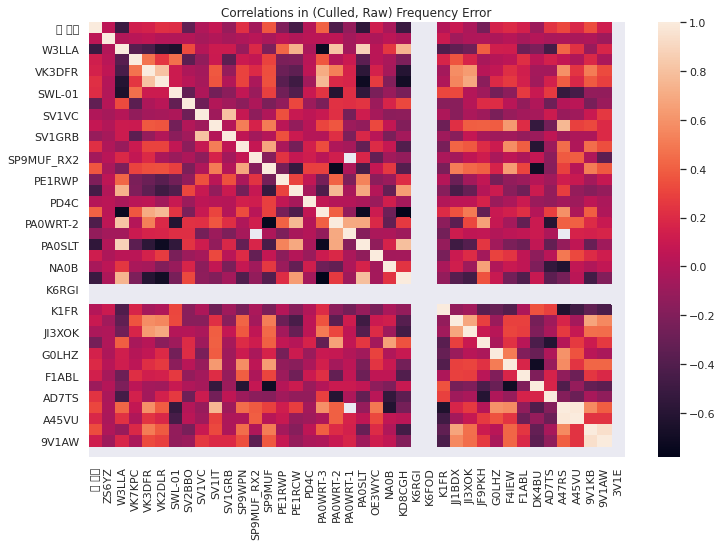

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(culled_FreqErrorCorrelations)
plt.title("Correlations in (Culled, Raw) Frequency Error")
plt.show()

"They've gone to plaid!" - KC

The Festival of Frequency Measurement was 01 October 2019 0000 to 2359 UTC.

In [ ]:
# date_timestamp = (pd.Timestamp("2019-10-01")
#                     .tz_localize("UTC"))
# date_string = date_timestamp.strftime("%Y-%m-%d")

Since the data is ordered nicely, we could just plot the points in order and ignore any sort of time information. However, it will be much nicer if we use a datetime index for the data.

We now have datetime objects as the index:

In [ ]:
Amplitude.head()


3V1E  3V8SS  9V1AW  9V1KB  A45VU  A47RS  AD7TS  DK4BU  EA1IUO  EI7IG2  F1ABL  F4IEW  G0LHZ  HZ1HM-SU9HM  JF9PKH  JI3XOK  JJ1BDX  K1FR  K6FOD  K6RGI  KD8CGH  NA0B  OE3WYC  PA0SLT  PA4WE  PD4C  PE1RCW  PE1RWP  SP9MUF  SP9WPN  SV1GRB     SV1IT  SV1ONK  SV1VC  SV2BBO  SWL-01  VK2DLR  VK3DFR  VK7KPC  W3LLA  ZS6YZ  罗智文
Time                                                                                                                                                                                                                                                                                                                                           
2020-06-14T19:14***   NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN     NaN    NaN    NaN    NaN          NaN     NaN     NaN     NaN   NaN    NaN    NaN     NaN   NaN     NaN     NaN    NaN   NaN     NaN     NaN     NaN     NaN     NaN  0.014418     NaN    NaN     NaN     NaN     NaN     NaN     NaN    NaN    NaN  NaN
2020-06-14T19:14***   NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN     NaN    NaN    NaN    NaN          NaN     NaN     NaN     NaN   NaN    NaN    NaN     NaN   NaN     NaN     NaN    NaN   NaN     NaN     NaN     NaN     NaN     NaN  0.019988     NaN    NaN     NaN     NaN     NaN     NaN     NaN    NaN    NaN  NaN
2020-06-14T19:14***   NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN     NaN    NaN    NaN    NaN          NaN     NaN     NaN     NaN   NaN    NaN    NaN     NaN   NaN     NaN     NaN    NaN   NaN     NaN     NaN     NaN     NaN     NaN  0.025648     NaN    NaN     NaN     NaN     NaN     NaN     NaN    NaN    NaN  NaN
2020-06-14T19:14***   NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN     NaN    NaN    NaN    NaN          NaN     NaN     NaN     NaN   NaN    NaN    NaN     NaN   NaN     NaN     NaN    NaN   NaN     NaN     NaN     NaN     NaN     NaN  0.030478     NaN    NaN     NaN     NaN     NaN     NaN     NaN    NaN    NaN  NaN
2020-06-14T19:14***   NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN     NaN    NaN    NaN    NaN          NaN     NaN     NaN     NaN   NaN    NaN    NaN     NaN   NaN     NaN     NaN    NaN   NaN     NaN     NaN     NaN     NaN     NaN  0.033626     NaN    NaN     NaN     NaN     NaN     NaN     NaN    NaN    NaN  NaN

## Bare basics

Let's just plot one of the stations' data. Local sunrise is the dotted line, sunset the solid one.

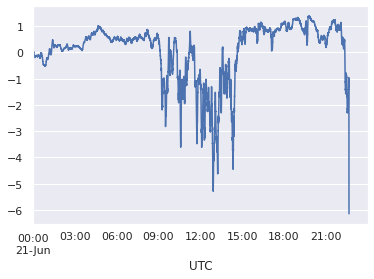

In [ ]:
Callsign="G0LHZ"
# pandas has some convient plotting functions built in, although datetimes are tricky.
# sr=pedigree.loc[pedigree[pedigree["Callsign"] == Callsign].index.values, "Sunrise"]
# sr=sr.values[0]
# ss=pedigree.loc[pedigree[pedigree["Callsign"] == Callsign].index.values, "Sunset"]
# ss=ss.values[0]

FreqError[Callsign].plot()
# plt.axvline(x=sr, ymin=-1, ymax=1, ls='--', color=[1, 0, 0])
# plt.axvline(x=ss, ymin=-1, ymax=1, ls='-', color=[1, 0, 0])
plt.show()

## Organize Data Geographically

###Using Plotly

From the latitude and longitude data, we can make a map of where the stations are. 

In [ ]:
linklist ='https://qrz.com/db/'+pedigree["Callsign"]
clicklist = str('<')+str('a href=')+str('"\"') + linklist+ str('/\>') + pedigree["Callsign"]
fig = px.scatter_geo(pedigree, "Latitude", "Longitude",
                     color="GPSDO", # which column to use to set the color of markers
                     hover_name=pedigree["Callsign"],#clicklist,#, # column added to hover information
#                      projection = 'albers usa',
                     )
fig.update_layout(title="Stations Submitting Data to the June Eclipse Festival")
fig.show()
fig.write_html(figures_dir +"stationmap.html") #export as html

Plotly Express is incredibly handy, but it only uses dots. For printing in black and white we need a version with different marker types. 

In [ ]:
df = pedigree
df.loc[48,"Callsign"] = 'SWL-02'
# from plotly.validators.scatter.marker import SymbolValidator
WWVlat = [40.678306]
WWVlong = [-105.040889]

markerlist=0+(df['GPSDO'].values == "Yes")
namelist = df['GPSDO'].values

#markerlist
fig = go.Figure(data=go.Scattergeo(
#         projection ='albers usa',
        locationmode = 'ISO-3',
        lon = df['Longitude'],
        lat = df['Latitude'],
        text = df['Callsign'],
        mode = 'markers',
        marker = dict(
            size = 8,
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol=markerlist,
#             colorscale=[[0, "rgb(166,206,227)"],[0.25, "rgb(31,120,180)"]],
            color = (markerlist+2)
        )
))

# Plot WWV:
fig.add_trace(go.Scattergeo(
        mode="markers+lines",
        lon=WWVlong,
        lat=WWVlat,
        name="WWV",
        marker={'size': 20,
               'color': 'Black',
                'line.color':'Orange',
               'symbol': 'star'}))


fig.update_layout(coloraxis = {'colorscale':'viridis'})
fig.update_layout(
#         title = 'Festival of Frequency Measurement Stations<br>',
        geo = dict(
            scope='world',
#             projection_type='albers usa',
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(90, 90, 90)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5
        )

    )

fig.update_layout(legend_title_text='GPSDO')
fig.update_layout(showlegend=False)

fig.show()

# fig.savefig('printmap.png')
# fig.write_image(figures_dir + "printmap.png")


Let's make a map of the stations with the relevant eclipse trace in it: 

In [ ]:
df = pedigree
# df.loc[48,"Callsign"] = 'SWL-02'
# from plotly.validators.scatter.marker import SymbolValidator
WWVlat = [40.678306]
WWVlong = [-105.040889]

markerlist=0+(df['GPSDO'].values == "Yes")
namelist = df['GPSDO'].values

fig.add_trace(go.Scattergeo(
#         projection ='albers usa',
        locationmode = 'ISO-3',
        lon = df['Longitude'],
        lat = df['Latitude'],
        text = df['Callsign'],
        mode = 'markers',
        name = '',
        marker = dict(
            size = 8,
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol=markerlist,
#             colorscale=[[0, "rgb(166,206,227)"],[0.25, "rgb(31,120,180)"]],
            color = (markerlist+2)
        )
))

# Plot WWV:
fig.add_trace(go.Scattergeo(
        mode="markers+lines",
        lon=WWVlong,
        lat=WWVlat,
        name="WWV",
        marker={'size': 20,
               'color': 'Black',
                'line.color':'Orange',
               'symbol': 'star'}))

# Plot BPM:
fig.add_trace(go.Scattergeo(
        mode="markers+lines",
        lon=[109.543036],
        lat=[34.948878],
        name="BPM",
        marker={'size': 20,
               'color': 'Black',
                'line.color':'Orange',
               'symbol': 'star'}))


fig.update_layout(coloraxis = {'colorscale':'viridis'})
# fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_layout(
#         title = 'Festival of Frequency Measurement Stations<br>',
        geo = dict(
            scope='world',
#             projection_type='albers usa',
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(90, 90, 90)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5
        )

    )



fig.update_layout(
    title="June Eclipse Stations",
    legend_title="Legend Title",
)

fig.update_layout(showlegend=False)
fig.update_layout(height=800, width=1800, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()
fig.write_html(figures_dir +"junemap.html") #export as html
# fig.write_image(figures_dir + "junemap.png")



In [ ]:
fig1 = px.choropleth(edf[0:1], geojson=geojson, color="date", locations="date", featureidkey="properties.date",center={"lat": 0, "lon": 90})
fig1.show()

###Using Matplotlib

We can then rearrange the stations according to longitude (and latitude, secondarily) and put the culled stations at the end. 

In [ ]:
pedigree.sort_values(by=['Status', 'Longitude', 'Latitude'], ascending=[1, 0, 1], inplace=True)


We'll create the stackedplot using matplotlib. First we'll generate a tiny map for each station that we can include in the stackedplot.

In [ ]:
gdf = geopandas.GeoDataFrame(pedigree, geometry=geopandas.points_from_xy(pedigree["Longitude"], pedigree["Latitude"]))
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))


id             date               type
0  9  Sun 21 Jun 2020  TotalPhasePolygon

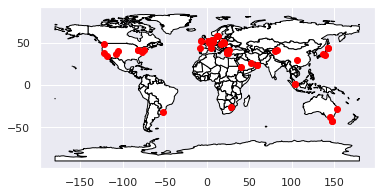

In [ ]:
ax = world.cx[-180:180,-90:90].plot(
    color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color='red')

#plt.show()
edf[0:1]

If we want to check any of the parameters of gdf:

In [ ]:
gdf.head()
gdf.dtypes
gdf.shape
pedigree.shape
gdf.total_bounds

array([-122.535   ,  -42.969   ,  153.421964,   57.9538  ])

##Stacked Plots

###Sample Plot

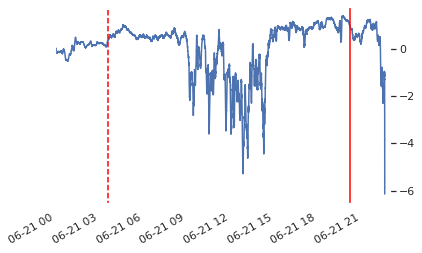

In [ ]:
Callsign="G0LHZ"    
sTime = datetime.datetime(2020,6,21,0,0)#(2017,8,21,16,0)
eTime = datetime.datetime(2020,6,21,23,0)#(2017,8,21,20,0)

# Create a vector of times to evaluate

dt    = datetime.timedelta(minutes=5)
q=1

times = [sTime]
while times[-1] < eTime:
  times.append(times[-1]+dt)
  q+=1
#obscuration calcs:
record = gdf[gdf["Callsign"] == Callsign].iloc[0]
obsc  = eclipse_calc.calculate_obscuration(times,record.Latitude,record.Longitude)
x = matplotlib.dates.date2num(times)
yarr = vstack((obsc,))


# pandas has some convient plotting functions built in, although datetimes are tricky.
fig, ax = plt.subplots()
axs = [ax, ax.twinx()]

sr=pedigree.loc[pedigree[pedigree["Callsign"] == Callsign].index.values, "Sunrise"]
sr=sr.values[0]
ss=pedigree.loc[pedigree[pedigree["Callsign"] == Callsign].index.values, "Sunset"]
ss=ss.values[0]

axs[1].plot(FreqError[Callsign])
axs[0].imshow(yarr, extent = [min(x),max(x), -1, 1], aspect = 'auto', cmap= 'binary')
axs[0].axes.get_yaxis().set_visible(False)
fig.autofmt_xdate()


plt.axvline(x=sr, ymin=-1, ymax=1, ls='--', color=[1, 0, 0])
plt.axvline(x=ss, ymin=-1, ymax=1, ls='-', color=[1, 0, 0])

plt.show()

####Using Plotly

Here is the same graph, but with plotly. It runs slower

In [ ]:
px.line(FreqError, x=FreqError.index, y="G0LHZ")

###Stacked Plots

Now let's create that stackedplot

In [ ]:
def suplabel(axis,label,label_prop=None,
             labelpad=5,
             ha='center',va='center'):
    ''' Add super ylabel or xlabel to the figure
    Similar to matplotlib.suptitle
    axis       - string: "x" or "y"
    label      - string
    label_prop - keyword dictionary for Text
    labelpad   - padding from the axis (default: 5)
    ha         - horizontal alignment (default: "center")
    va         - vertical alignment (default: "center")
    
    from https://stackoverflow.com/a/29107972/10008497
    '''
    fig = plt.gcf()
    xmin = []
    ymin = []
    for ax in fig.axes:
        xmin.append(ax.get_position().xmin)
        ymin.append(ax.get_position().ymin)
    xmin,ymin = min(xmin),min(ymin)
    dpi = fig.dpi
    if axis.lower() == "y":
        rotation=90.
        x = xmin-float(labelpad)/dpi
        y = 0.5
    elif axis.lower() == 'x':
        rotation = 0.
        x = 0.5
        y = ymin - float(labelpad)/dpi
    else:
        raise Exception("Unexpected axis: x or y")
    if label_prop is None: 
        label_prop = dict()
    plt.text(x,y,label,rotation=rotation,
               transform=fig.transFigure,
               ha=ha,va=va,
               **label_prop)

Here's the function we'll use to make stackplots. It includes sunrise and sunset times and maps for each station.

In [ ]:
from mpl_toolkits.axes_grid1 import Divider, Size
from mpl_toolkits.axes_grid1.mpl_axes import Axes

#debugging previous cell...
def stackedplot2(df, n=None, start=0, sharey=False, amplitude_df=None, mask_df=None, date_limit=None):
    """
    Make a stacked plot for the first n columns in df.
    
    stackedplot2 uses matplotlib, and won't lock up the computer
    forever. Just a while.
    
    Returns a figure object.
    
    start: the first index to plot (default: 0)
    n: the number of columns to plot (default: all the columns)


    """
    if n is None:
        n = df.columns.size
        
    if mask_df is not None:
        fill_df = ~mask_df
    
    fig, axes = plt.subplots(nrows=n, ncols=3, sharey=sharey, 
                             gridspec_kw={'width_ratios': [4, 1, 1]})
    
    world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
    padding = 10

    i=0
    previous_amplitude_axis = None
    
    for Callsign in tqdm(df.columns[start:(start + n)], desc="Making stackedplot"):
# #     Full world map
        mapbounds = [-180,   180  ,  -90,   90]

        # data
        sr=pedigree.loc[pedigree[pedigree["Callsign"] == Callsign].index.values, "Sunrise"]
        sr=sr.values[0]
#         print('Sunrise for ', Callsign, sr)
        ss=pedigree.loc[pedigree[pedigree["Callsign"] == Callsign].index.values, "Sunset"]
        ss=ss.values[0]
        print('Sunset for ', Callsign, ss)
        
        # ECLIPSE OBSCURATION:
        # Create a vector of times to evaluate
        sTime = datetime.datetime(2020,6,21,0,0)#(2017,8,21,16,0)
        eTime = datetime.datetime(2020,6,22,0,0)#(2017,8,21,20,0)
        dt    = datetime.timedelta(minutes=5)
        q=1

        times = [sTime]
        while times[-1] < eTime:
            times.append(times[-1]+dt)
            q+=1
        #obscuration calcs:
        record = gdf[gdf["Callsign"] == Callsign].iloc[0]
        obsc   = eclipse_calc.calculate_obscuration(times,record.Latitude,record.Longitude)
        x2     = matplotlib.dates.date2num(times)
        yarr   = vstack((obsc,)) 

        # obscuration code needs to be on first axis otherwise it covers the plot
        axes[i,0].imshow(yarr, extent = [min(x2),max(x2), -1, 1], aspect = 'auto', cmap= 'binary')
        axes[i,0].axes.get_yaxis().set_visible(False)
        axes[i,0].axes.get_xaxis().set_visible(False)

        freq_axis = axes[i,0].twinx()
        freq_axis.plot(df[Callsign])
        freq_axis.axvline(x=sr, ymin=-1, ymax=1, ls='--', color=[1, 0, 0])
        freq_axis.axvline(x=ss, ymin=-1, ymax=1, ls='-', color=[1, 0, 0])    
        freq_axis.get_xaxis().set_visible(False) 
        
        axes[i,0].grid(False)
        freq_axis.grid(False)

        #testing this...
        if date_limit is not None:
            foo = axes[i, 0].set_xlim([day, day+timedelta(1)])
        
        if amplitude_df is not None:
            amplitude_axis = freq_axis.twinx()
            amplitude_axis.plot(amplitude_df[Callsign], 'r')
            if sharey == 'col' and i != 0: 
                amplitude_axis.get_shared_y_axes().join(amplitude_axis, previous_amplitude_axis)
             previous_amplitude_axis = amplitude_axis
            amplitude_axis.grid(False)
        
        if mask_df is not None:
            limits = axes[i,0].get_ylim()
            axes[i,0].fill_between(df.index, limits[0], limits[1], where=fill_df[Callsign],
                                   color="white", alpha=1)
            # see https://github.com/matplotlib/matplotlib/issues/3872
            #collection = collections.BrokenBarHCollection.span_where(
            #    df.index, ymin=0, ymax=1, where=mask_df[zID], facecolor='green', alpha=0.5)
            #ax.add_collection(collection)
        # TODO make time scale visible

        # location map
        world.cx[-180:180,-90:90].plot(ax=axes[i,1],
            color='white', edgecolor='black')
        gdf[gdf["Callsign"] == Callsign].plot(ax=axes[i,1], color='red')
        axes[i,1].tick_params(labelleft=False, labelbottom=False)
        
        # station info
        record = gdf[gdf["Callsign"] == Callsign].iloc[0]
        text = ("Callsign: {callsign}\n"
                "Latitude: {latitude:.4}\n"
                "Longitude: {longitude:.4}\n"
                "GPSDO: {gpsdo}").format(callsign=record.Callsign,
                                          status=record.Status,
                                          latitude=record.Latitude,
                                          longitude=record.Longitude,
                                          gpsdo=record["GPSDO"])
        axes[i, 2].text(0, 0, text)
        axes[i, 2].axis('off')
        i+=1
        
    
    axes[n - 1, 0].get_xaxis().set_major_formatter(matplotlib.dates.DateFormatter('%m/%d %H:%M'))
    plt.setp(axes[n-1,0].get_xticklabels(), rotation=30, ha="right")
        
    axes[n-1, 0].get_xaxis().set_visible(True) #testing this...
    
    axes[0, 0].set_title("Submitted Frequency Data")
    axes[0, 1].set_title("Map")
    axes[0, 2].set_title("Info")
    
    axes[n - 1, 0].set_xlabel("Time (UTC)")
    
    suplabel("y", "Frequency Deviation (Hz)")
     
    return fig
    gdf[gdf["Callsign"] == Callsign].iloc[0]

Let's test this out with a small set of plots. 

In [ ]:
fig = stackedplot2(FreqError, n=5, start=0, mask_df=FreqErrorMask, date_limit='None')
print('Figure created.')


IndexError: ignored


Error in callback <function flush_figures at 0x7f43f84ad320> (for post_execute):


KeyboardInterrupt: ignored

Here's where we generate the split stackedplot so it can be printed easily on a single page. This cell will take a while to run:

Sunset for  ZS6YZ 2020-06-21 15:25:00+00:00
Sunset for  W3LLA 2020-06-21 02:35:00+00:00
Sunset for  VK7KPC 2020-06-21 06:44:00+00:00
Sunset for  VK3DFR 2020-06-21 07:07:00+00:00
Sunset for  VK2DLR 2020-06-21 06:57:00+00:00
Sunset for  SWL-01 2020-06-21 06:43:00+00:00
Sunset for  SV2BBO 2020-06-21 18:02:00+00:00
Sunset for  SV1VC 2020-06-21 17:50:00+00:00
Sunset for  SV1IT 2020-06-21 17:50:00+00:00
Sunset for  SV1GRB 2020-06-21 17:51:00+00:00
Sunset for  SP9WPN 2020-06-21 18:59:00+00:00
Sunset for  SP9MUF_RX2 2020-06-21 18:53:00+00:00
Sunset for  SP9MUF 2020-06-21 18:53:00+00:00
Sunset for  PE1RWP 2020-06-21 20:06:00+00:00
Sunset for  PE1RCW 2020-06-21 20:18:00+00:00
Sunset for  PD4C 2020-06-21 20:05:00+00:00
Sunset for  PA0WRT-3 2020-06-21 20:03:00+00:00
Sunset for  PA0WRT-2 2020-06-21 20:03:00+00:00
Sunset for  PA0WRT-1 2020-06-21 20:03:00+00:00
Sunset for  PA0SLT 2020-06-21 20:04:00+00:00



Sunset for  OE3WYC 2020-06-21 18:58:00+00:00
Sunset for  NA0B 2020-06-21 14:14:00+00:00
Sunset for  KD8CGH 2020-06-21 01:02:00+00:00
Sunset for  K6RGI 2020-06-21 03:36:00+00:00
Sunset for  K6FOD 2020-06-21 03:07:00+00:00
Sunset for  K1FR 2020-06-21 00:37:00+00:00
Sunset for  JJ1BDX 2020-06-21 10:00:00+00:00
Sunset for  JI3XOK 2020-06-21 10:16:00+00:00
Sunset for  JF9PKH 2020-06-21 10:13:00+00:00
Sunset for  G0LHZ 2020-06-21 20:17:00+00:00
Sunset for  F4IEW 2020-06-21 19:59:00+00:00
Sunset for  F1ABL 2020-06-21 19:26:00+00:00
Sunset for  DK4BU 2020-06-21 19:49:00+00:00
Sunset for  AD7TS 2020-06-21 04:10:00+00:00
Sunset for  A47RS 2020-06-21 14:56:00+00:00
Sunset for  A45VU 2020-06-21 14:56:00+00:00
Sunset for  9V1KB 2020-06-21 11:12:00+00:00
Sunset for  9V1AW 2020-06-21 11:13:00+00:00
Sunset for  3V1E 2020-06-21 15:27:00+00:00



ValueError: ignored

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f43f84a6cb0> (for post_execute):


ValueError: ignored

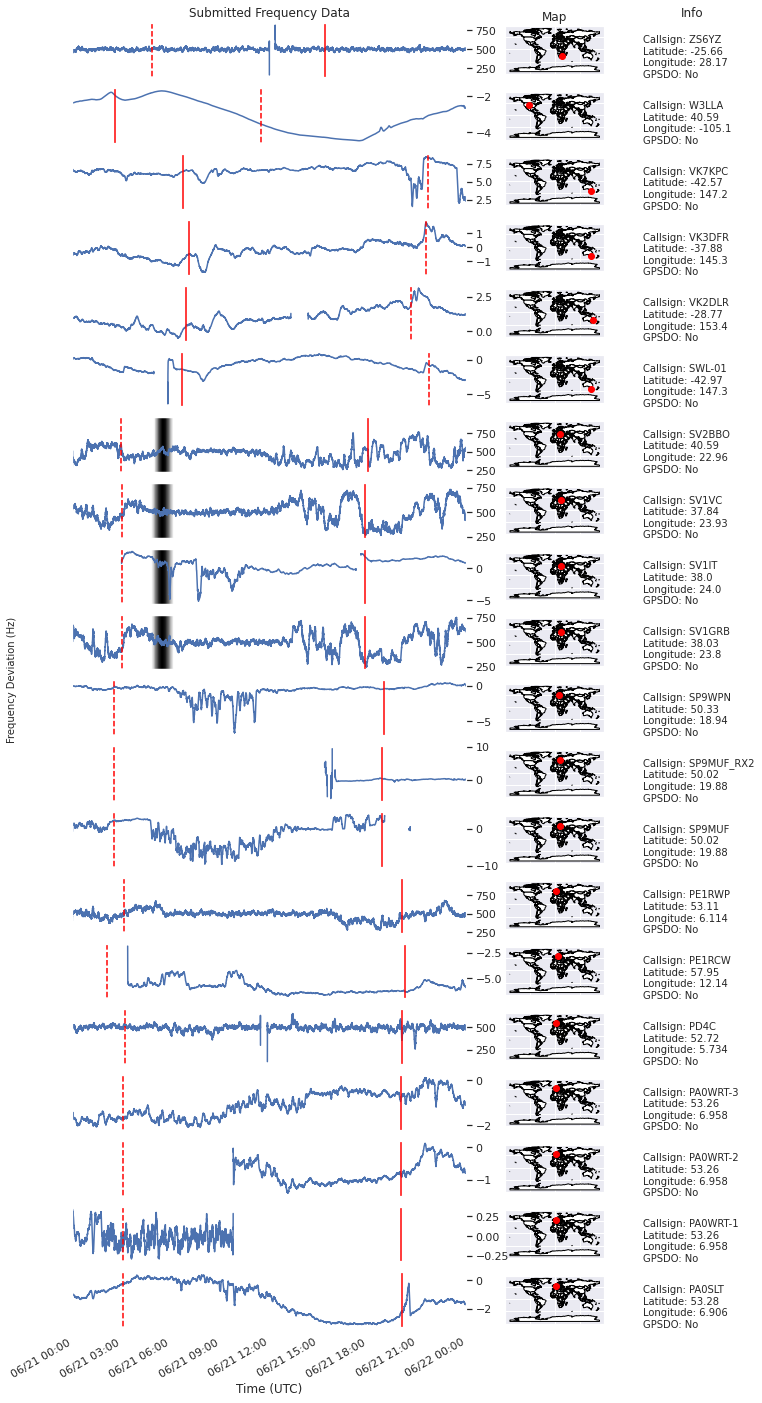

ValueError: ignored

<Figure size 864x1728 with 79 Axes>

In [ ]:
if PLOT_STACKEDPLOTS:
    # make the two-columns layout for paper
    first_in_column_two = int(np.ceil(FreqError.columns.size/2))
    sizes = [first_in_column_two, FreqError.columns.size - first_in_column_two]
    print(sizes)
    
    fig1 = stackedplot2(FreqError, n=sizes[1], start=1, mask_df=FreqErrorMask, amplitude_df=Amplitude, date_limit='None')# date_limit=1)
    fig1.set_size_inches(12,24)
#     fig.tight_layout()
    fig1.savefig(figures_dir + daystring+"_stackedplot-split-1.png", bbox_inches="tight", pad_inches=0)
    
    fig2 = stackedplot2(FreqError, n=sizes[1], start=first_in_column_two, mask_df=FreqErrorMask, amplitude_df=Amplitude, date_limit='None')#, date_limit=1)
    fig2.set_size_inches(12,24)
    #fig2.savefig('paper-stackedplot-split-2.png')
    #fig.tight_layout()
    fig2.savefig(figures_dir + daystring + "_stackedplot-split-2.png", bbox_inches="tight", pad_inches=0)
#     FreqError=qux

In [ ]:
print(FreqError.columns[1:(1+sizes[1])])
print(FreqError.columns[first_in_column_two:(first_in_column_two+sizes[1])])
print(FreqError.columns[0])


Index(['ZS6YZ', 'W3LLA', 'VK7KPC', 'VK3DFR', 'VK2DLR', 'SWL-01', 'SV2BBO', 'SV1VC', 'SV1IT', 'SV1GRB', 'SP9WPN', 'SP9MUF_RX2', 'SP9MUF', 'PE1RWP', 'PE1RCW', 'PD4C', 'PA0WRT-3', 'PA0WRT-2', 'PA0WRT-1', 'PA0SLT'], dtype='object')
Index(['PA0SLT', 'OE3WYC', 'NA0B', 'KD8CGH', 'K6RGI', 'K6FOD', 'K1FR', 'JJ1BDX', 'JI3XOK', 'JF9PKH', 'G0LHZ', 'F4IEW', 'F1ABL', 'DK4BU', 'AD7TS', 'A47RS', 'A45VU', '9V1KB', '9V1AW', '3V1E'], dtype='object')
罗 智文


Sunset for  PA0SLT 2020-06-21 20:04:00+00:00
Sunset for  PA0WRT-1 2020-06-21 20:03:00+00:00
Sunset for  PA0SLT 2020-06-21 20:04:00+00:00
Sunset for  OE3WYC 2020-06-21 18:58:00+00:00
Sunset for  NA0B 2020-06-21 14:14:00+00:00
Sunset for  KD8CGH 2020-06-21 01:02:00+00:00
Sunset for  K6RGI 2020-06-21 03:36:00+00:00
Sunset for  K6FOD 2020-06-21 03:07:00+00:00
Sunset for  K1FR 2020-06-21 00:37:00+00:00
Sunset for  JJ1BDX 2020-06-21 10:00:00+00:00
Sunset for  JI3XOK 2020-06-21 10:16:00+00:00
Sunset for  JF9PKH 2020-06-21 10:13:00+00:00
Sunset for  G0LHZ 2020-06-21 20:17:00+00:00
Sunset for  F4IEW 2020-06-21 19:59:00+00:00
Sunset for  F1ABL 2020-06-21 19:26:00+00:00
Sunset for  DK4BU 2020-06-21 19:49:00+00:00
Sunset for  AD7TS 2020-06-21 04:10:00+00:00
Sunset for  A47RS 2020-06-21 14:56:00+00:00
Sunset for  A45VU 2020-06-21 14:56:00+00:00
Sunset for  9V1KB 2020-06-21 11:12:00+00:00
Sunset for  9V1AW 2020-06-21 11:13:00+00:00

##Eclipse Map

This code that creates an Eclipse Map is separate from the rest of the notebook. It is https://github.com/HamSCI/eclipse_calculator/blob/master/eclipse_maps.py with different dates. 

If you only want to create the eclipse map, run these two cells, make sure to uncomment the installs in the first cell, if the code in the Intro wasn't run.

In [ ]:
"""
#git libaries used
!pip install --user git+https://github.com/matplotlib/basemap.git
!pip install --user git+https://github.com/HamSCI/eclipse_calculator.git

#mount drive to get data from and save files to
from google.colab import drive
drive.mount('/content/drive')
#"""

"\n#git libaries used\n!pip install --user git+https://github.com/matplotlib/basemap.git\n!pip install --user git+https://github.com/HamSCI/eclipse_calculator.git\n\n#mount drive to get data from and save files to\nfrom google.colab import drive\ndrive.mount('/content/drive')\n#"

In [ ]:
#!/usr/bin/env python3
import os
import datetime
from collections import OrderedDict
import multiprocessing

import numpy as np
import pandas as pd

import matplotlib as mpl
mpl.use("Agg")
from matplotlib import pyplot as plt

from astropy.coordinates import EarthLocation

import eclipse_calc

def location_dict(precision=2,height=0.):
    gs_grid     = eclipse_calc.locator.gridsquare_grid(precision=precision).flatten()
    ll_grid     = eclipse_calc.locator.gridsquare2latlon(gs_grid)
    lats,lons   = ll_grid

    dd              = OrderedDict()
    dd['grid']      = gs_grid
    dd['lat']       = lats
    dd['lon']       = lons
    dd['height']    = np.ones(lats.shape)*height
#    dd['loc']   = [EarthLocation.from_geodetic(lon,lat,height) for lat,lon in zip(lats,lons)]
    return dd

def plot_eclipse_dict(run_dict):
    return plot_eclipse(**run_dict)

def plot_eclipse(date,loc_dict,region='world',cmap=mpl.cm.gray_r,output_dir='output'):
    """
    region: 'us' or 'world"
    height: [km]
    """
    # Define output paths.
    date_str    = date.strftime('%Y%m%d_%H%M')
    fname       = '{!s}_{!s}km_eclipseObscuration'.format(date_str,int(height/1000))
    fpath       = os.path.join(output_dir,fname)
    print('Processing {!s}...'.format(fpath))

    # Set up data dictionary.
    dd          = OrderedDict()
    dd['grid']  = loc_dict['grid']
    dd['lat']   = loc_dict['lat']
    dd['lon']   = loc_dict['lon']
    dd['height']= loc_dict['height']
#    locs        = loc_dict['loc']

    # Eclipse Magnitude
#    dd['obsc']  = np.array([eclipse_calc.calculate_obscuration(date,loc=loc) for loc in locs])
    dates       = np.array(len(dd['lat'])*[date])
    dd['obsc']  = eclipse_calc.calculate_obscuration(dates,dd['lat'],dd['lon'],height=dd['height'])
#    dd['obsc']  = dd['lat'] # Useful for debugging plotting.

    # Store into dataframe.
    df          = pd.DataFrame(dd)
    df          = df.set_index('grid')

    # Save CSV Datafile.
    csv_path    = fpath+'.csv'
    with open(csv_path,'w') as fl:
        fl.write('# Solar Eclipse Obscuration file for {!s}\n'.format(date))
    df.to_csv(csv_path,mode='a')

    # Plot data.
    map_prm = {}
    if region == 'world':
        # Map boundaries for the world
        map_prm['llcrnrlon'] = -180.
        map_prm['llcrnrlat'] = -90
        map_prm['urcrnrlon'] = 180.
        map_prm['urcrnrlat'] = 90.
    else:
        # Map boundaries for the United States
        map_prm['llcrnrlon'] = -130.
        map_prm['llcrnrlat'] =   20.
        map_prm['urcrnrlon'] =  -60.
        map_prm['urcrnrlat'] =   55.

    vmin        = 0.
    vmax        = 1.
    cbar_ticks  = np.arange(0,1.1,0.1)

    fig         = plt.figure(figsize=(12,10))
    ax          = fig.add_subplot(111)
    hmap        = eclipse_calc.maps.HamMap(date,date,ax,show_title=False,**map_prm)
    hmap.overlay_gridsquares(label_precision=0,major_style={'color':'0.8','dashes':[1,1]})
    hmap.overlay_gridsquare_data(dd['grid'],dd['obsc'],vmin=vmin,vmax=vmax,cbar_ticks=cbar_ticks,
                zorder=5,cmap=cmap,cbar_shrink=0.5,cbar_label='Obscuration')

    title       = '{!s} Height: {!s} km'.format(date.strftime('%d %b %Y %H%M UT'),height/1000.)
    fontdict    = {'size':'x-large','weight':'bold'}
    hmap.ax.text(0.5,1.025,title,fontdict=fontdict,transform=ax.transAxes,ha='center')
    fig.tight_layout()
    fig.savefig(fpath+'.png',bbox_inches='tight')

    plt.close(fig)

    return fpath

def getMaps(output_dir, sDate, eDate, timeDelta):
    eclipse_calc.gen_lib.clear_dir(output_dir,php=True)

    dt      = datetime.timedelta(minutes=timeDelta)

    precision   = 4
    height      = 300e3

    loc_dict    = location_dict(precision=precision,height=height)

    run_list    = []
    cDate       = sDate
    while cDate < eDate:
        tmp = OrderedDict()
        tmp['date']         = cDate
        tmp['loc_dict']     = loc_dict
        tmp['output_dir']   = output_dir
        run_list.append(tmp)
        cDate   += dt

    with multiprocessing.Pool() as pool:
        pool.map(plot_eclipse_dict,run_list)

height      = 300e3


In [ ]:
if MAP:
  getMaps(figures_dir, datetime.datetime(2020,12,14,14), datetime.datetime(2020,12,14,15), 5)

Processing drive/Shared drives/Solar Eclipse Data Analysis/filtered_plots/20201214_1400_300km_eclipseObscuration...
Processing drive/Shared drives/Solar Eclipse Data Analysis/filtered_plots/20201214_1410_300km_eclipseObscuration...
Processing drive/Shared drives/Solar Eclipse Data Analysis/filtered_plots/20201214_1405_300km_eclipseObscuration...
Processing drive/Shared drives/Solar Eclipse Data Analysis/filtered_plots/20201214_1415_300km_eclipseObscuration...
Processing drive/Shared drives/Solar Eclipse Data Analysis/filtered_plots/20201214_1420_300km_eclipseObscuration...
Processing drive/Shared drives/Solar Eclipse Data Analysis/filtered_plots/20201214_1430_300km_eclipseObscuration...
Processing drive/Shared drives/Solar Eclipse Data Analysis/filtered_plots/20201214_1425_300km_eclipseObscuration...
Processing drive/Shared drives/Solar Eclipse Data Analysis/filtered_plots/20201214_1435_300km_eclipseObscuration...
Processing drive/Shared drives/Solar Eclipse Data Analysis/filtered_plot